#### Library

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

#### Data Loading

In [2]:
df = pd.read_csv('/home/kevin/Downloads/BESS/data/data_June2024_Dec2024/merged_df_June2024_Dec2024.csv')

#### Data Processing

In [3]:
df.shape

(5139, 11)

In [4]:
df.head()

,datetime_,pool_price,forecast_pool_price,rolling_30day_avg_price,alberta_internal_load,forecast_alberta_internal_load,solar_generation,wind_generation,temp_calgary,temp_edmonton,temp_fortmc
0,2024-06-01 00:00:00,30.83,24.30,35.38,8703,8662,0.0,1017.402785,9.9,4.1,5.9
1,2024-06-01 01:00:00,20.23,23.25,35.36,8724,8625,0.0,1294.319027,6.5,5.1,5.4
2,2024-06-01 02:00:00,13.56,18.02,35.34,8657,8649,0.0,1678.965264,5.9,5.7,5.1
3,2024-06-01 03:00:00,10.53,11.00,35.32,8634,8632,0.0,1959.930783,3.4,5.6,5.4
4,2024-06-01 04:00:00,12.43,10.09,35.31,8606,8632,0.0,1713.419408,4.2,4.7,4.0


In [5]:
df.isnull().sum()

datetime_                          0
pool_price                         0
forecast_pool_price                0
rolling_30day_avg_price            0
alberta_internal_load              0
forecast_alberta_internal_load     0
solar_generation                  24
wind_generation                   24
temp_calgary                       7
temp_edmonton                     13
temp_fortmc                        8
dtype: int64

In [ ]:
df['solar_generation'].fillna(df.solar_generation.median(), inplace=True)
df['wind_generation'].fillna(df.wind_generation.median(), inplace=True)
df['temp_calgary'].fillna(df.temp_calgary.median(), inplace=True)
df['temp_edmonton'].fillna(df.temp_edmonton.median(), inplace=True)
df['temp_fortmc'].fillna(df.temp_fortmc.median(), inplace=True)

In [7]:
df.isnull().sum()

datetime_                         0
pool_price                        0
forecast_pool_price               0
rolling_30day_avg_price           0
alberta_internal_load             0
forecast_alberta_internal_load    0
solar_generation                  0
wind_generation                   0
temp_calgary                      0
temp_edmonton                     0
temp_fortmc                       0
dtype: int64

In [8]:
# we have 7 months of data

# use 6 months of data to train ML model
    # independer variable: solar_generation, wind_generation, temp_calgary, temp_edmonton, temp_fortmc
    # target variable: pool_price

# use 1 month of data to test ML model

In [13]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 6 months
train_data = df[df['datetime_'] < '2024-12-01']

# Define independent variables (features) and target variable
X_train = train_data[['solar_generation', 'wind_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc']]
y_train = train_data['pool_price']

# Display the shapes of the training data
print(X_train.shape, y_train.shape)

(4395, 5) (4395,)


In [12]:
# Initialize the XGBoost regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Display the model
print(xgb_regressor)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [14]:
# Filter data for the first 6 months
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
X_test = test_data[['solar_generation', 'wind_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc']]
y_test = test_data['pool_price']

# Display the shapes of the training data
print(X_test.shape, y_test.shape)

(744, 5) (744,)


In [19]:
# Make predictions on the training data
y_train_pred = xgb_regressor.predict(X_train)

# Display the predictions
print(y_train_pred)
# Calculate mean squared error for training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {train_mse}")

# Calculate R^2 score for training data
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train R^2 Score: {train_r2}")

[36.51424  26.664284 16.57348  ... 36.07465  32.313175 55.596436]
Train Mean Squared Error: 2549.14907406528
Train R^2 Score: 0.8168865265956317


In [18]:
# Make predictions on the test data
y_pred = xgb_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error: 9718.10625784205
R^2 Score: -17.512706156549704


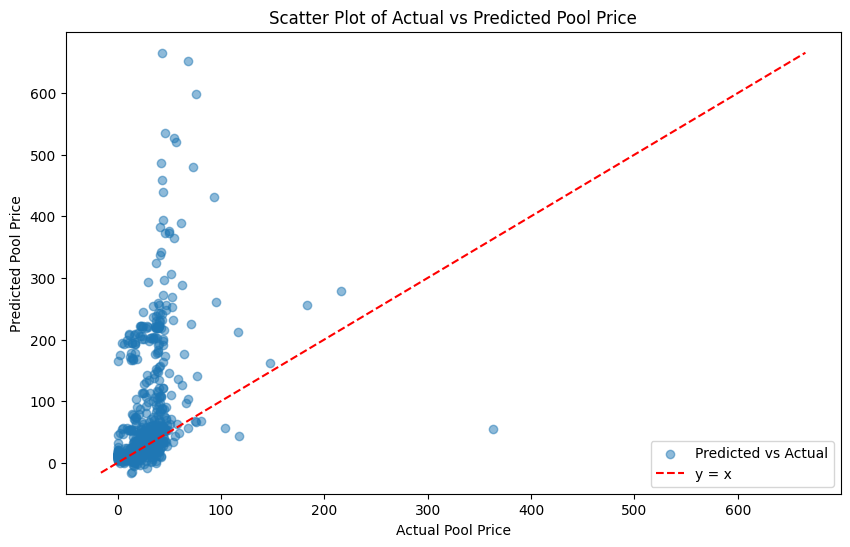

In [23]:
# Assuming y_test and y_pred are already defined
# Generate values for the y = x line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line_values = np.linspace(min_val, max_val, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot the y = x line
plt.plot(line_values, line_values, color='red', linestyle='--', label='y = x')

# Add labels and title
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Scatter Plot of Actual vs Predicted Pool Price')

# Add a legend
plt.legend()

# Show the plot
plt.show()